## It has been done in Kaggle with their 30 hours of Free GPU resource [T4 GPU X 2]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from sklearn.metrics import fbeta_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

import torch
import random
from datasets import Dataset
from collections import defaultdict

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
df = pd.read_csv('/kaggle/input/news-article-biasness/final_dataset_for_classification_processed.csv')

In [ ]:
# print(torch.cuda.is_available())  # Should print True
# print(torch.cuda.device_count())  # Should be >= 1
# print(torch.cuda.get_device_name(0))  # Should print your GPU name

In [ ]:
# df = pd.read_csv('final_dataset_for_classification_processed.csv')

In [5]:
label2id = {"Left-leaning": 0, "Centrist": 1, "Right-leaning": 2}
id2label = {v: k for k, v in label2id.items()}

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [7]:
# model_name = "allenai/longformer-base-4096"
model_name = "google/bigbird-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [8]:
def tokenize(batch):
    return tokenizer(
        batch["processed_title"],
        batch["processed_content"],
        padding="max_length",
        truncation=True,
        max_length=4096
    )

In [9]:
train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True).remove_columns(["processed_title", "processed_content"])
val_dataset = Dataset.from_pandas(val_df).map(tokenize, batched=True).remove_columns(["processed_title", "processed_content"])
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True).remove_columns(["processed_title", "processed_content"])

Map:   0%|          | 0/930 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [10]:
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
    output_dir="./bigbird-roberta-base",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=1
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
def compute_metrics_fn(beta):
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {f"f{beta}_score": fbeta_score(labels, preds, beta=beta, average='weighted')}
    return compute_metrics

In [14]:
final_results = defaultdict(dict)

# early_stopping = EarlyStoppingCallback(
#     early_stopping_patience=8,  # Stop if no improvement after 6 evaluation steps
#     early_stopping_threshold=0.0  # Minimum change to qualify as an improvement
# )

for beta in [1.8]:
    print(f"\nTraining and evaluating for F{beta} score")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        # callbacks=[early_stopping],
        compute_metrics=compute_metrics_fn(beta)
        )
    
    trainer.train()
    val_result = trainer.evaluate(val_dataset)
    final_results[f"F{beta} Validation"] = val_result

    # Final test set prediction
    test_pred_logits = trainer.predict(test_dataset).predictions
    test_preds = np.argmax(test_pred_logits, axis=1)
    test_labels = test_dataset["label"]
    test_fbeta = fbeta_score(test_labels, test_preds, beta=beta, average="weighted")
    report = classification_report(
        test_labels, test_preds,
        target_names=list(id2label.values()),
        zero_division=0
    )

    final_results[f"F{beta} Test"] = {
        "f_beta": test_fbeta,
        "classification_report": report
    }

    print(f"\nClassification Report for F{beta} Test:")
    print(report)


Training and evaluating for F1.8 score


/tmp/ipykernel_35/308298875.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1.8 Score
1,0.791200,1.180229,0.743070
2,0.751500,1.167736,0.713829
3,0.785500,0.950998,0.761156
4,0.636300,1.010993,0.753287
5,0.937600,1.034087,0.753287


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Classification Report for F1.8 Test:
               precision    recall  f1-score   support

 Left-leaning       0.67      0.56      0.61        62
     Centrist       0.00      0.00      0.00         5
Right-leaning       0.79      0.88      0.83       133

     accuracy                           0.76       200
    macro avg       0.49      0.48      0.48       200
 weighted avg       0.73      0.76      0.74       200



In [15]:
trainer.save_model("./bigbird-roberta_best_model")

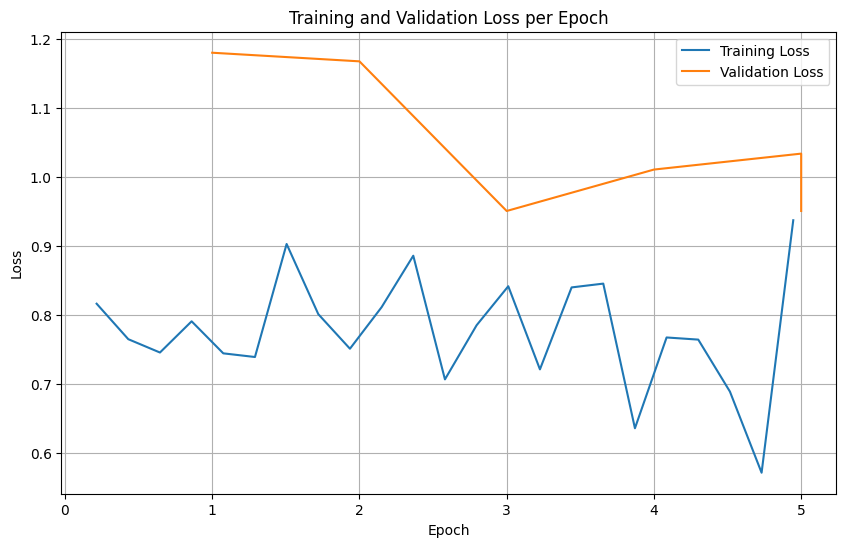

In [ ]:
def plot_loss(trainer):

    if not hasattr(trainer, 'state') or not hasattr(trainer.state, 'log_history'):
        print("Trainer state or log_history not available. Cannot plot loss.")
        return

    log_history = trainer.state.log_history

    train_loss = []
    train_epochs = []
    eval_loss = []
    eval_epochs = []

    for entry in log_history:
        if 'loss' in entry and 'epoch' in entry:
            train_loss.append(entry['loss'])
            train_epochs.append(entry['epoch'])
        if 'eval_loss' in entry and 'epoch' in entry:
            eval_loss.append(entry['eval_loss'])
            eval_epochs.append(entry['epoch'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_epochs, train_loss, label='Training Loss')
    plt.plot(eval_epochs, eval_loss, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(trainer)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Confusion Matrix ---


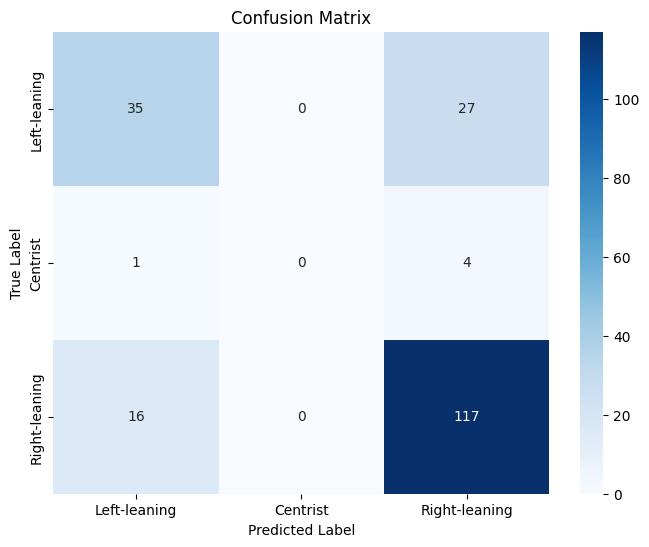


--- ROC Curve ---


AttributeError: 'Tensor' object has no attribute 'astype'

<Figure size 1000x800 with 0 Axes>

In [ ]:
test_pred_output = trainer.predict(test_dataset)
test_pred_logits = test_pred_output.predictions
test_preds = np.argmax(test_pred_logits, axis=1)
test_labels = test_dataset["label"]

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve For multiclass, you can plot ROC for each class vs the rest (One-vs-Rest)
print("\n--- ROC Curve ---")
test_pred_probabilities = torch.softmax(torch.tensor(test_pred_logits), dim=1).numpy()s), dim=1).numpy()

plt.figure(figsize=(10, 8))
for i, class_name in id2label.items():
    y_true_bin = (test_labels == i).astype(int)
    y_score = test_pred_probabilities[:, i]

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (class {class_name}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Download required NLTK data (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_wordnet_pos(treebank_tag):
    """
    Map POS tag from nltk.pos_tag (Penn Treebank) to WordNet POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(tokens)

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
    ]

    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [20]:
def predict_bias(headline, content):
    processed_headline = preprocess_text(headline)
    processed_content = preprocess_text(content)

    inputs = tokenizer(
        processed_headline,
        processed_content,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=4096
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return id2label[predicted_class]


In [21]:
#Right-leaning Example
headline = "Government's Decisive Action Strengthens National Security, Exposes Opposition Weakness"

content = """In a bold move hailed by nationalists and security experts alike, the government has launched a comprehensive crackdown on illegal infiltrators along the northeastern border. Officials confirmed that the operation, coordinated between the Border Security Force (BSF) and the Intelligence Bureau, has already led to over 400 arrests and the dismantling of several sleeper cells suspected of anti-national activities.

Home Minister Amit Shah emphasized the government's unwavering commitment to protecting India's sovereignty, stating, "This is not just a border operation—it’s a message to every enemy of India." Critics, largely from opposition parties, have called the move politically motivated, but public sentiment suggests otherwise. A recent poll shows 78% of respondents supporting the crackdown as a necessary step to preserve national integrity.

Meanwhile, liberal commentators continue to argue for leniency and "humanitarian concerns," revealing once again a disconnect between elite narratives and the ground realities faced by citizens. Many view this operation as a reaffirmation of Prime Minister Modi's strong leadership and India's resolve in the face of threats—internal and external.

As the dust settles, one thing is clear: the era of soft policy and strategic hesitation is over."""

predict_bias(headline, content)

'Right-leaning'

In [22]:
#Left-leaning Example

headline = "Widening Inequality and Erosion of Freedoms Raise Alarms in New Economic Policy Rollout"

content = """As the government unveils its latest economic reform package touted as a growth accelerator, activists and economists warn of its regressive impact on India’s working class and marginalized communities. The decision to further privatize core public sector enterprises and reduce regulatory safeguards for labor rights has drawn sharp criticism from civil society groups and opposition leaders.

“This policy is a textbook example of trickle-down economics that never trickles down,” said social activist Medha Patkar. “While corporates are handed tax breaks and land concessions, the rural poor continue to face rising food prices, stagnant wages, and shrinking welfare schemes.”

Critics also point to the increased concentration of media and institutional power, which they argue undermines the democratic accountability of such sweeping policy decisions. Several journalists and researchers have expressed concern over the silencing of dissenting voices and the branding of criticism as anti-national.

Meanwhile, the government insists the reforms are necessary to improve investor confidence and global competitiveness. However, data suggests that economic inequality has widened during recent quarters, with the top 1% holding more than 40% of national wealth.

As debates intensify, the question remains: can India pursue rapid growth without sacrificing the social contract and hard-won democratic values?"""

predict_bias(headline, content)

'Left-leaning'

In [23]:
#Left-leaning Example - 2

headline = "Ceasefire on UN orders, BJP MLA says"

content = """New Delhi: Sometimes Colonel Sophia Qureshi is called the sister of terrorists, sometimes BJP leaders have given credit for Operation Sindoor to the Prime Minister. The controversy over this has not subsided. The saffron minister of Madhya Pradesh has also had to listen to the Supreme Court's rebuke. Even then, there is no stopping. Padma Party MLA Narendra Prajapati is once again making a fuss about the glory of the Indian military. The Madhya Pradesh public representative claims that the operation that was started under the leadership of Prime Minister Narendra Modi would have ended the entire Pakistan. However, India agreed to a ceasefire with Pakistan only after the UN order. As soon as his comment went viral, there was a storm of criticism from various quarters. The BJP MLA's explanation on damage control, the media has presented his comment in a confusing way. He said some things out of emotion. They are being misinterpreted."""

predict_bias(headline, content)

'Left-leaning'

In [30]:
### Tough to classify Right-leaning

headline = "Educational Reform Aims to Strengthen National Identity and Global Competence"

content = """The Ministry of Education unveiled a new curriculum framework this week, introducing a series of changes designed to foster both national pride and international competitiveness among students. The revised syllabus includes greater emphasis on India’s civilizational achievements, traditional knowledge systems, and foundational constitutional values.

“For decades, our textbooks have overlooked large parts of India’s intellectual legacy,” said one senior official involved in drafting the changes. “This isn’t about rewriting history, but about reclaiming historical balance.”

The initiative also includes enhanced STEM modules, coding in primary classes, and increased focus on global skills and soft diplomacy — ensuring students are not only rooted in their heritage but also prepared for the global economy.

While some educators have praised the reforms for integrating culture with modern pedagogy, a few academic voices have expressed concerns about potential ideological overtones. However, public response has been largely positive, especially from parents and rural education advocates who feel the new curriculum offers a more relatable and aspirational roadmap.

Analysts note that the changes reflect a broader shift in educational priorities across the globe, where countries are reasserting cultural distinctiveness in an increasingly homogenized world. The government maintains that the reforms are apolitical, student-centered, and aligned with national development goals."""

predict_bias(headline, content)

'Left-leaning'

In [32]:
### Tough to classify Left-leaning

headline = "Policy Experts Urge Focus on Inclusive Growth as Inequality Trends Persist"

content = """As India reports a steady uptick in quarterly GDP figures, economists and policy researchers are calling for a parallel emphasis on equity-oriented reforms to ensure that growth reaches all segments of society. Recent data from the National Sample Survey indicates that while urban incomes have grown by 8.3%, rural wage growth remains sluggish, with certain informal sectors still recovering from the economic shock of the pandemic.

“No one is denying the importance of growth, but the distributional aspect cannot be ignored,” said a senior researcher at a Delhi-based think tank. “We need to prioritize foundational services — healthcare, education, food security — especially in underserved areas.”

The government has increased capital spending and incentivized private infrastructure projects, which many analysts agree is crucial for long-term productivity. However, experts warn that without concurrent investment in human capital, the demographic dividend may remain underutilized.

Independent surveys show a widening gender gap in labor participation and a decline in formal employment opportunities for recent graduates — trends that have persisted despite broader macroeconomic gains. Several policy briefs recommend targeted interventions such as conditional cash transfers, rural employment guarantees, and education-linked subsidies to bridge these gaps.

With India poised to become the world’s third-largest economy, analysts argue that a dual focus on competitiveness and inclusion will be essential for maintaining long-term social cohesion and political stability."""

predict_bias(headline, content) ## Still giving perfect classification

'Left-leaning'

In [24]:
##Centrist Example

headline = "New Economic Reforms Spark Debate Over Growth Strategy and Social Impact"

content = """The Indian government has announced a new set of economic reforms aimed at boosting investment and accelerating GDP growth. The policy includes further privatization of state-owned enterprises and regulatory changes designed to improve the ease of doing business.

Supporters argue that these measures are necessary to modernize India’s economy and attract foreign capital. "These reforms send a strong signal that India is open for business," said a senior official from the Ministry of Finance. "We expect increased job creation and long-term economic benefits."

However, labor unions and civil society groups have raised concerns about the potential social costs. Critics worry that the reforms could reduce labor protections and widen the gap between rich and poor. They also caution against weakening the public sector in areas such as healthcare and education.

Economists remain divided. While some applaud the government's market-oriented approach, others stress the importance of maintaining inclusive growth. Independent data indicates that while overall investment has increased, income inequality also remains a pressing issue.

As the country moves forward, the success of the reform package will likely depend on its implementation and the balance struck between economic efficiency and social equity."""

predict_bias(headline, content) ## Mis-classifying as expected

'Left-leaning'

In [34]:
## Republic News

headline = "India Rules Out Quick Thaw in Ties with Turkey After Ankara Backs Pakistan"

content = """Briefing the Standing Committee on External Affairs on Monday, Foreign Secretary Vikram Misri told MPs that New Delhi does not expect a thaw with Ankara any time soon. According to people present at the closed‑door meeting, Misri noted that Turkey “made its stand very clear in its support to Pakistan” and India therefore “does not see the relations … becoming normalised in the near future.”

Committee members from across party lines—including Shashi Tharoor, Asaduddin Owaisi and Abhishek Banerjee—attended the briefing, which focused on the objectives and results of Operation Sindoor.

Why relations soured
Operation Sindoor: Launched on 7 May after a terror attack killed 26 civilians in Pahalgam, the Indian operation struck nine terrorist camps inside Pakistan and Pakistan‑occupied Jammu and Kashmir.

Turkish support for Pakistan: Ankara publicly criticised India’s strikes as “provocative” and, according to Indian officials, supplied Turkish‑made Baykar Yiha III kamikaze drones that Pakistan later used in cross‑border attacks.

Drone interceptions: India’s air‑defence network—featuring S‑400 and Akash systems—shot down multiple drones and missiles between 7 and 10 May.

The episode came barely a year after India’s humanitarian “Operation Dost” sent relief teams to Turkey following the February 2023 earthquake.

Wider diplomatic backdrop
Turkish President Recep Tayyip Erdoğan has also made disturbing comments on Kashmir, recently telling Pakistani Prime Minister Shehbaz Sharif that Ankara is ready to “explore ways to assist” on the issue—remarks India views as interference in its internal affairs.

During Monday’s committee session, MPs pressed the foreign secretary on several related topics, including:

US President Donald Trump’s claim of brokering last week’s cease‑fire.

Domestic criticism from Congress MP Rahul Gandhi over India’s diplomatic handling of the crisis.

Misri underscored that any future provocations—whether via drones, missiles or terror strikes—would be met with “strong” action by India’s armed forces.

What happens next?
Officials in New Delhi expect bilateral engagement with Ankara to remain minimal. Any near‑term improvement will likely depend on Turkey distancing itself from Pakistan‑based terrorist activity—a prospect Indian diplomats currently consider remote."""

predict_bias(headline, content)

'Right-leaning'